In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Dataset -> CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
# Resize to 224x224 for ResNet50
IMG_SIZE = 32
BATCH = 32

In [ ]:
def preprocess_images(images):
    images = tf.image.resize(images, (IMG_SIZE, IMG_SIZE))
    return images

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(lambda x,y: (preprocess_input(preprocess_images(tf.cast(x, tf.float32))), y))
train_ds = train_ds.shuffle(5000).batch(BATCH).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(lambda x,y: (preprocess_input(preprocess_images(tf.cast(x, tf.float32))), y))
test_ds = test_ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Validation split from training
val_size = int(0.1 * len(x_train))
val_ds = train_ds.take(val_size // BATCH)
train_ds = train_ds.skip(val_size // BATCH)

In [ ]:
num_classes = 10

Build Model

In [ ]:
def build_model(base_model, trainable=True):
    base_model.trainable = trainable
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs)

In [ ]:
def compile_and_train(model, epochs=10, lr=1e-3):
    model.compile(optimizer=optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    cb = [
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
        callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cb)
    return history

In [ ]:
def plot_history(history, title):
    plt.plot(history.history["accuracy"], label="train acc")
    plt.plot(history.history["val_accuracy"], label="val acc")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

ResNet-50 From scratch


 Training ResNet50 from scratch : 
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 120s 47ms/step - accuracy: 0.2756 - loss: 2.7326 - val_accuracy: 0.1911 - val_loss: 125.7655 - learning_rate: 0.0010
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 94s 30ms/step - accuracy: 0.2652 - loss: 2.5521 - val_accuracy: 0.2386 - val_loss: 344.1876 - learning_rate: 0.0010
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.3379 - loss: 2.1026 - val_accuracy: 0.3960 - val_loss: 2.2308 - learning_rate: 0.0010
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - accuracy: 0.4079 - loss: 1.9349 - val_accuracy: 0.4311 - val_loss: 7.7897 - learning_rate: 0.0010
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.4416 - loss: 1.8349 - val_accuracy: 0.4716 - val_loss: 1.5972 - learning_rate: 0.0010
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.4777 - loss: 1.6781 - val_accuracy: 0.4583 - val_loss: 3.5377 - learning_rate: 0.0010
Epoch 7/20
1407/1407 ━━

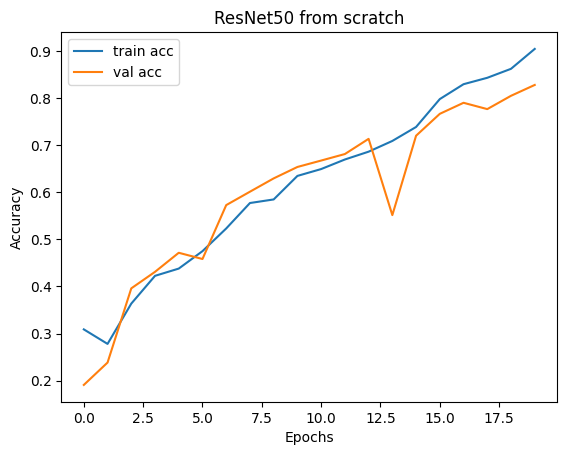

In [ ]:
print("\n Training ResNet50 from scratch : ")
base_scratch = ResNet50(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_scratch = build_model(base_scratch, trainable=True)
hist_scratch = compile_and_train(model_scratch, epochs=20, lr=1e-3)
plot_history(hist_scratch, "ResNet50 from scratch")

In [ ]:
model_scratch.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,718,368 (269.77 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,110,166 (179.71 MB)

Feature Extraction With Pretrained model


 Training ResNet50 with ImageNet weights (frozen backbone)...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - accuracy: 0.4613 - loss: 2.7520 - val_accuracy: 0.6168 - val_loss: 1.3470 - learning_rate: 0.0010
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5689 - loss: 1.6974 - val_accuracy: 0.6116 - val_loss: 1.3418 - learning_rate: 0.0010
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5609 - loss: 1.7083 - val_accuracy: 0.6112 - val_loss: 1.3749 - learning_rate: 0.0010
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5691 - loss: 1.6830 - val_accuracy: 0.6340 - val_loss: 1.3177 - learning_rate: 0.0010
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5756 - loss: 1.6823 - val_accuracy: 0.6206 - val_loss: 1.3889 - learning_rate: 0.0010
Epoch 6/10
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5684 - loss: 1.7217
Epoch 6: ReduceLROn

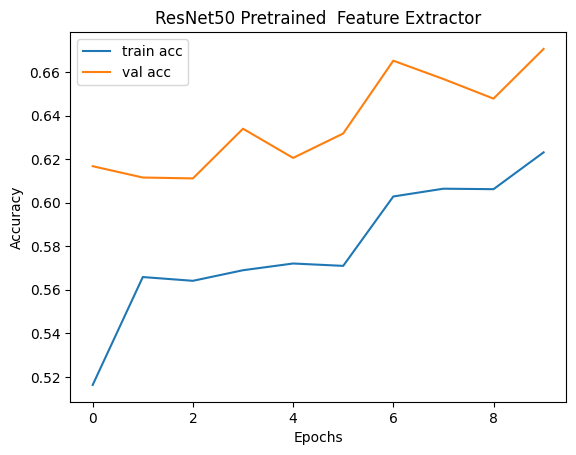

In [ ]:
print("\n Training ResNet50 with ImageNet weights (frozen backbone)...")
base_pretrained = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_feature = build_model(base_pretrained, trainable=False)
hist_feat = compile_and_train(model_feature, epochs=10, lr=1e-3)
plot_history(hist_feat, "ResNet50 Pretrained  Feature Extractor")

In [ ]:
model_feature.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649,184 (90.21 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 40,982 (160.09 KB)

Fine tuning with Pretrained model


 Fine-tuning last layers of ResNet50...
Epoch 1/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 27ms/step - accuracy: 0.4471 - loss: 2.0367 - val_accuracy: 0.7159 - val_loss: 0.8370 - learning_rate: 1.0000e-04
Epoch 2/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.6906 - loss: 0.9224 - val_accuracy: 0.7648 - val_loss: 0.6945 - learning_rate: 1.0000e-04
Epoch 3/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7516 - loss: 0.7375 - val_accuracy: 0.8049 - val_loss: 0.5722 - learning_rate: 1.0000e-04
Epoch 4/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.7896 - loss: 0.6235 - val_accuracy: 0.8221 - val_loss: 0.5165 - learning_rate: 1.0000e-04
Epoch 5/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.8234 - loss: 0.5076 - val_accuracy: 0.8425 - val_loss: 0.4633 - learning_rate: 1.0000e-04
Epoch 6/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8580 - loss: 0.4142 - val_accuracy: 0.8732 - val_loss: 0.3843 - learning_rate: 1.0000e-04

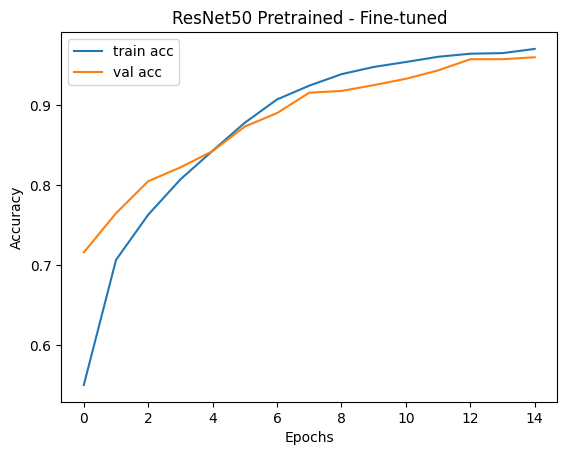

In [ ]:
print("\n Fine-tuning last layers of ResNet50...")
base_finetune = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# Freeze most layers, unfreeze last 50
for layer in base_finetune.layers[:-50]:
    layer.trainable = False
model_finetune = build_model(base_finetune, trainable=True)
hist_finetune = compile_and_train(model_finetune, epochs=15, lr=1e-4)
plot_history(hist_finetune, "ResNet50 Pretrained - Fine-tuned")

In [ ]:
model_finetune.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,550,240 (219.54 MB)

 Trainable params: 16,971,018 (64.74 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

 Optimizer params: 33,942,038 (129.48 MB)

Evaluation and comparision

In [ ]:
def evaluate_and_report(model, title):
    print(f"\n Evaluation: {title}")
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")

    y_pred = np.argmax(model.predict(test_ds), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Sample predictions
    sample_images, sample_labels = next(iter(test_ds.unbatch().batch(16)))
    preds = np.argmax(model.predict(sample_images), axis=1)
    plt.figure(figsize=(12,6))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(sample_images[i].numpy().astype("uint8"))
        plt.title(f"T:{class_names[sample_labels[i]]}\nP:{class_names[preds[i]]}")
        plt.axis("off")
    plt.show()


 Evaluation: Scratch
Test Accuracy: 0.7143
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


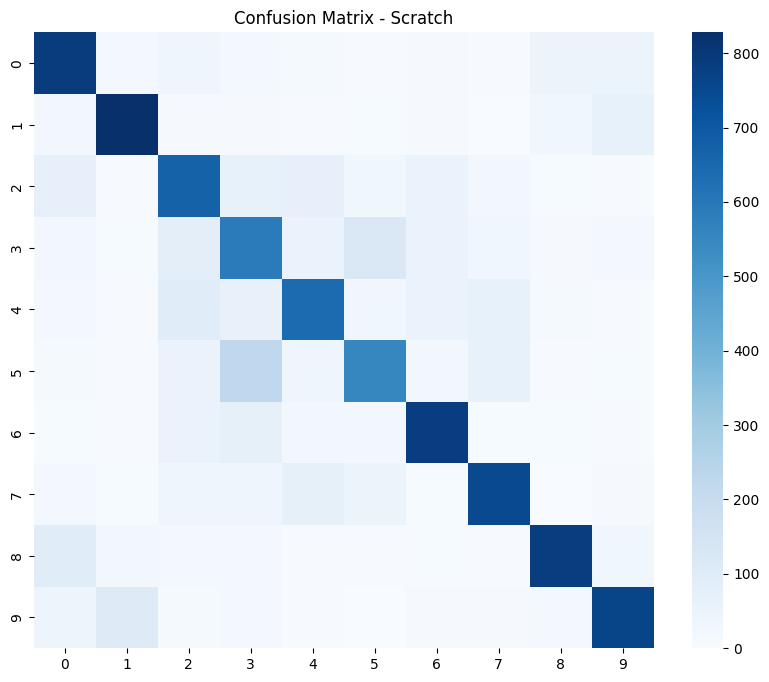


Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.79      0.74      1000
  automobile       0.82      0.83      0.82      1000
        bird       0.61      0.67      0.64      1000
         cat       0.52      0.59      0.55      1000
        deer       0.68      0.64      0.66      1000
         dog       0.66      0.55      0.60      1000
        frog       0.77      0.78      0.77      1000
       horse       0.77      0.75      0.76      1000
        ship       0.85      0.78      0.81      1000
       truck       0.80      0.77      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


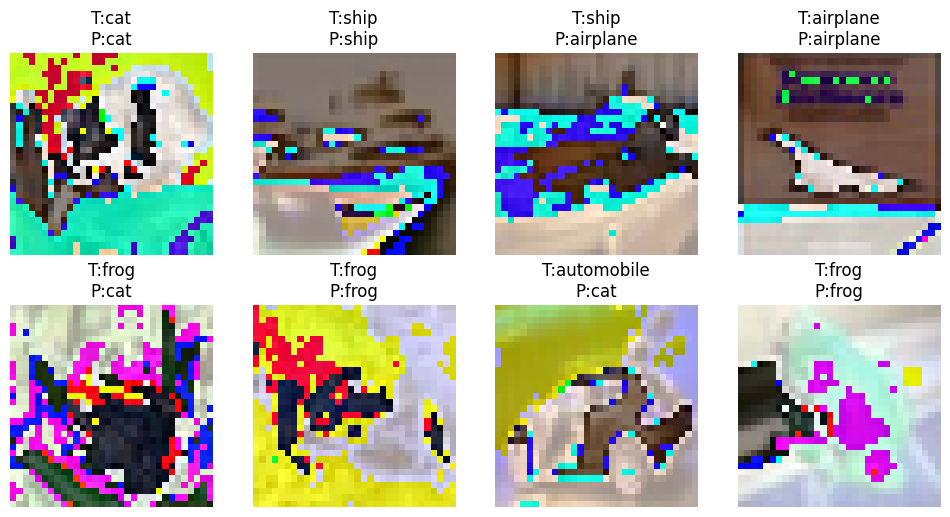


 Evaluation: Pretrained Feature Extractor
Test Accuracy: 0.6550
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step


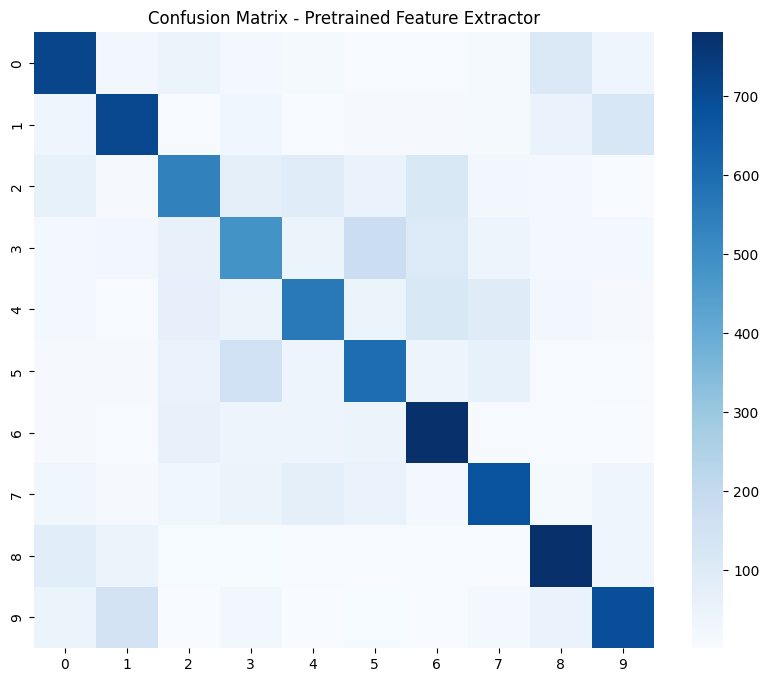


Classification Report:
              precision    recall  f1-score   support

    airplane       0.68      0.72      0.70      1000
  automobile       0.71      0.71      0.71      1000
        bird       0.61      0.54      0.57      1000
         cat       0.52      0.48      0.50      1000
        deer       0.64      0.56      0.60      1000
         dog       0.60      0.60      0.60      1000
        frog       0.64      0.78      0.70      1000
       horse       0.70      0.68      0.69      1000
        ship       0.72      0.78      0.75      1000
       truck       0.71      0.69      0.70      1000

    accuracy                           0.66     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.66      0.65     10000

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


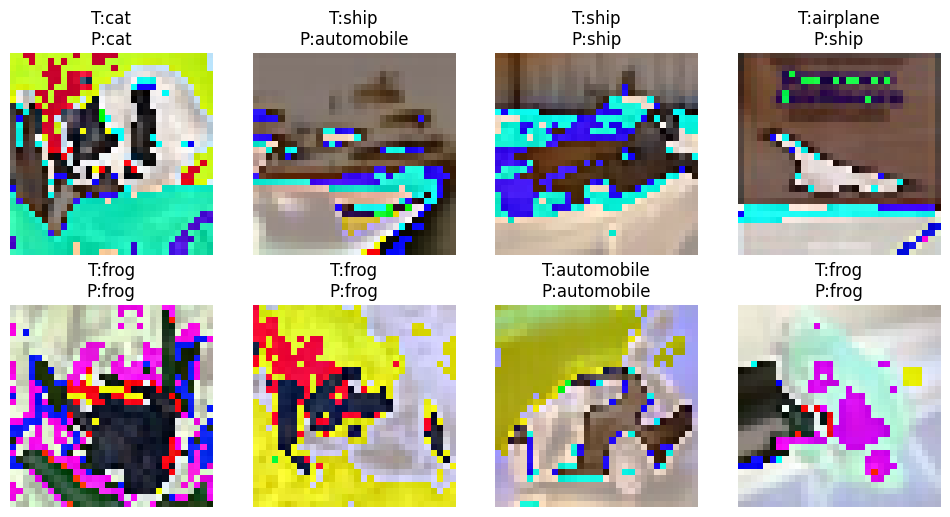


 Evaluation: Pretrained Fine-tuned
Test Accuracy: 0.7659
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step


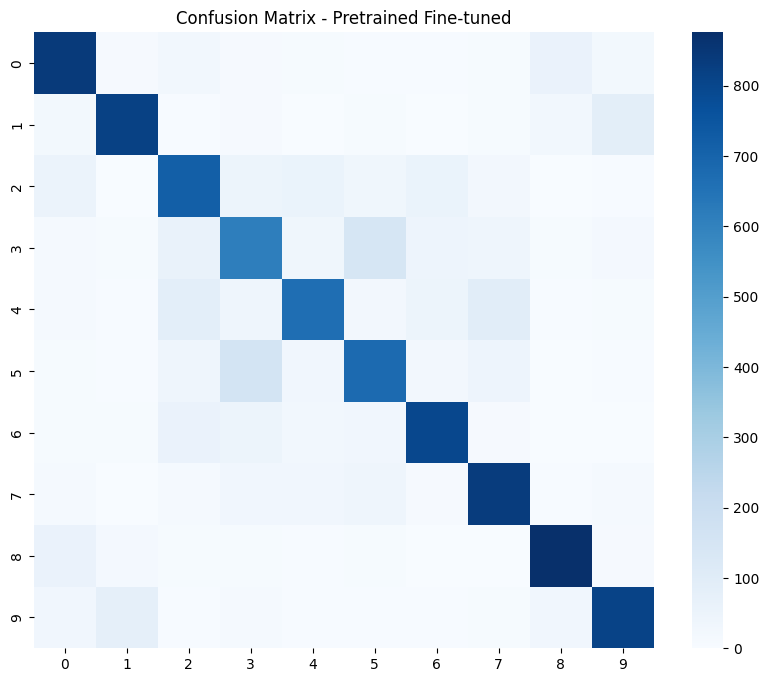


Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.84      0.81      1000
  automobile       0.86      0.82      0.84      1000
        bird       0.70      0.72      0.71      1000
         cat       0.62      0.61      0.62      1000
        deer       0.76      0.67      0.71      1000
         dog       0.69      0.68      0.68      1000
        frog       0.80      0.80      0.80      1000
       horse       0.77      0.83      0.80      1000
        ship       0.86      0.88      0.87      1000
       truck       0.82      0.81      0.82      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


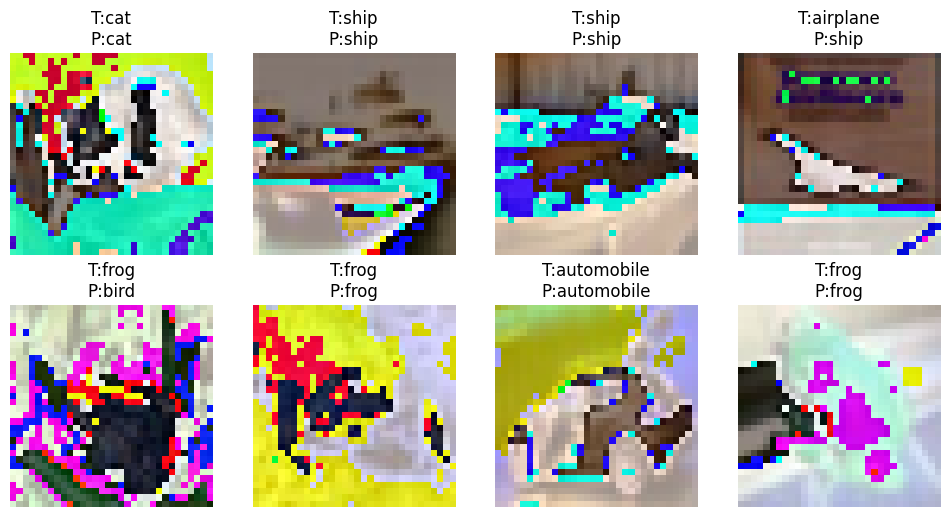

In [ ]:
evaluate_and_report(model_scratch, "Scratch")
evaluate_and_report(model_feature, "Pretrained Feature Extractor")
evaluate_and_report(model_finetune, "Pretrained Fine-tuned")

Summary

In [ ]:
results = {
    "Scratch": model_scratch.evaluate(test_ds, verbose=0)[1],
    "Pretrained (Frozen)": model_feature.evaluate(test_ds, verbose=0)[1],
    "Pretrained (Fine-tuned)": model_finetune.evaluate(test_ds, verbose=0)[1]
}
print("\n✅ Final Accuracy Comparison (CIFAR-10):")
for k,v in results.items():
    print(f"{k}: {v:.4f}")


✅ Final Accuracy Comparison (CIFAR-10):
Scratch: 0.7143
Pretrained (Frozen): 0.6550
Pretrained (Fine-tuned): 0.7659
